 ## Revenue during each day of the next month.

# Import libraries


In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import timedelta

import xgboost as xg
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Load data

In [2]:
server = 'mohamedibrahim'
database = 'railway_dwh'

connection_string = (
    f'mssql+pyodbc://mohamedibrahim/railway_dwh'
    '?driver=ODBC+Driver+17+for+SQL+Server'
    '&Trusted_Connection=yes'
)
engine = create_engine(connection_string)

query = """
SELECT 
    date_of_purchase,
    SUM(price) AS revenue
FROM silver.railway
WHERE refund_request = 'No'
GROUP BY date_of_purchase
ORDER BY date_of_purchase
"""
df = pd.read_sql(query, engine)

# Preprocessing & Feature engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date_of_purchase  128 non-null    object
 1   revenue           128 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [4]:
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'])

In [5]:
df.head()

,date_of_purchase,revenue
0,2023-12-08,43
1,2023-12-16,23
2,2023-12-19,3
3,2023-12-20,13
4,2023-12-27,76


In [6]:
df.set_index('date_of_purchase', inplace=True)

In [7]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day

In [8]:
import holidays


uk_holidays = holidays.UnitedKingdom(subdiv='ENG', years=2024, observed=True)
df['is_holiday'] = df.index.map(lambda x: x in uk_holidays)


In [9]:
df['is_holiday'] = df['is_holiday'].astype(int)


In [10]:
df['lag 1'] = df['revenue'].shift(1).fillna(0)
df['lag 7'] = df['revenue'].shift(7).fillna(0)
df['lag 14'] = df['revenue'].shift(14).fillna(0)


In [11]:
df['lag 1'] = df['lag 1'].astype(int)
df['lag 7'] = df['lag 7'].astype(int)
df['lag 14'] = df['lag 14'].astype(int)

# Forecasting

## Prepare Train & Test data

In [12]:
train = df.loc[df.index < '2024-04-11']
test = df.loc[df.index >= '2024-04-11']

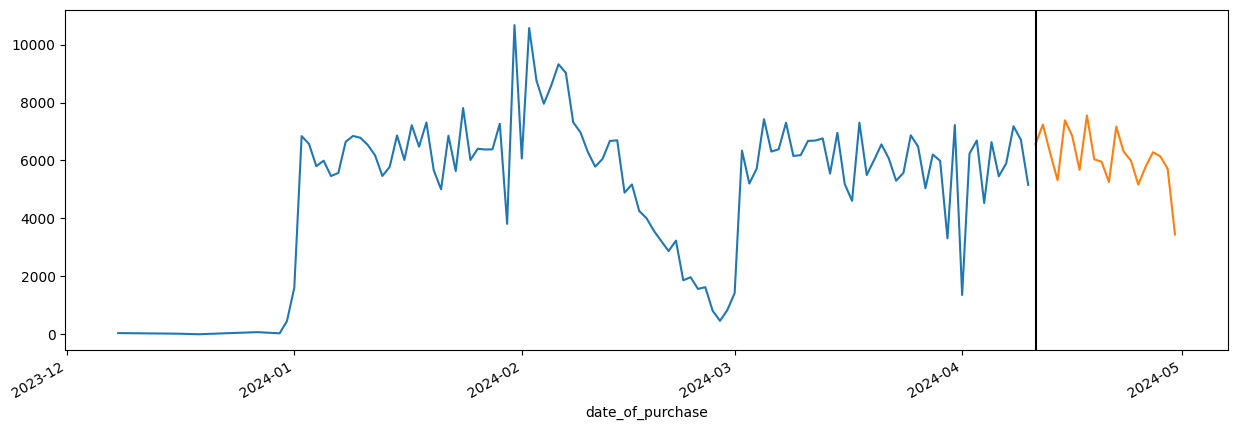

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
train['revenue'].plot(ax=ax,label='tarining set')
test['revenue'].plot(ax=ax,label='test set')
ax.axvline('2024-04-11', color='black')
plt.show()


## Creat model

In [14]:
# define the features
features = [
    'month', 'day', 'day_of_week', 'is_holiday', 'lag 1', 'lag 7', 'lag 14'
    ]

In [15]:
# prepare the training data
x_train = train[features]
y_train = train['revenue']

x_test = test[features]
y_test = test['revenue']

In [17]:
# train XGBOOST model
model = xg.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.15,
    max_depth = 2,
    random_state = 42,
    early_stopping_rounds = 30
)

model.fit(
    x_train, 
    y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True
)



[0]	validation_0-rmse:2130.65460	validation_1-rmse:1106.68191
[1]	validation_0-rmse:1951.82817	validation_1-rmse:1040.34518
[2]	validation_0-rmse:1801.91056	validation_1-rmse:1008.58779
[3]	validation_0-rmse:1689.71635	validation_1-rmse:977.00082
[4]	validation_0-rmse:1599.97215	validation_1-rmse:960.67643
[5]	validation_0-rmse:1511.38231	validation_1-rmse:938.85084
[6]	validation_0-rmse:1448.41878	validation_1-rmse:934.07409
[7]	validation_0-rmse:1385.46905	validation_1-rmse:920.11374
[8]	validation_0-rmse:1340.83030	validation_1-rmse:888.91335
[9]	validation_0-rmse:1295.66546	validation_1-rmse:885.03261
[10]	validation_0-rmse:1264.61930	validation_1-rmse:884.14287
[11]	validation_0-rmse:1230.55507	validation_1-rmse:874.50431
[12]	validation_0-rmse:1197.38468	validation_1-rmse:849.83133
[13]	validation_0-rmse:1168.60020	validation_1-rmse:853.03206
[14]	validation_0-rmse:1133.98409	validation_1-rmse:826.47527
[15]	validation_0-rmse:1109.33732	validation_1-rmse:827.11256
[16]	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

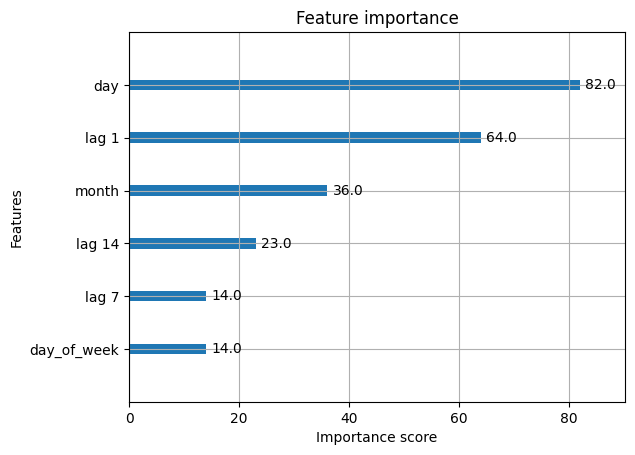

In [18]:
xg.plot_importance(model)
plt.show()


In [19]:
# Make predictions
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)


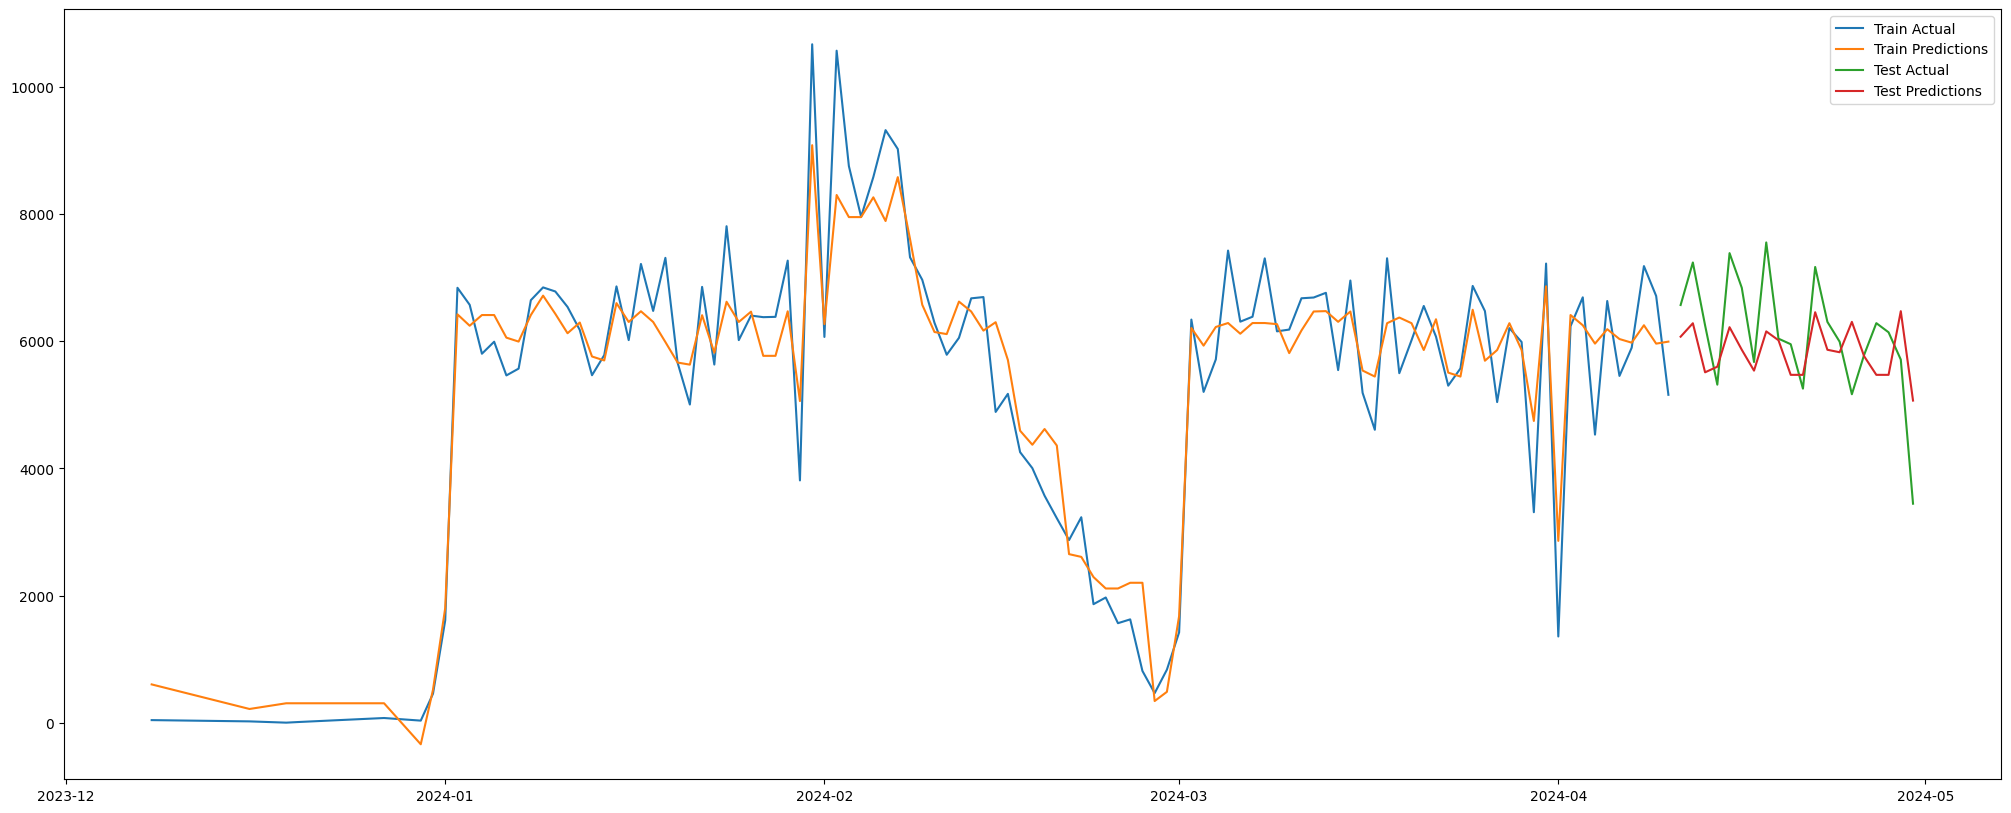

In [20]:
# Plot results
plt.figure(figsize=(25,10))
plt.plot(train.index, y_train.rolling(window=1).mean(), label='Train Actual')
plt.plot(train.index, pd.Series(train_preds).rolling(window=1).mean(), label='Train Predictions')
plt.plot(test.index, y_test.rolling(window=1).mean(), label='Test Actual')
plt.plot(test.index, pd.Series(test_preds).rolling(window=1).mean(), label='Test Predictions')
plt.legend()
plt.show()


## Forecasting the Next Month 


In [ ]:
# Create a dataframe for the next 30 days
last_date = df.index.max()
next_month_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)
future_df = pd.DataFrame(index=next_month_dates)


In [22]:
# Prepare holiday map
future_df['day_of_week'] = future_df.index.dayofweek
future_df['month'] = future_df.index.month
future_df['day'] = future_df.index.day
future_df['is_holiday'] = future_df.index.map(lambda x: x in uk_holidays).astype(int)


In [23]:

# Copy original dataframe to append predictions for lag calculation
history = df.copy()

# Placeholder for predictions
predictions = []


In [24]:

# Forecast each day one by one (recursive approach)
for date in future_df.index:
    row = {}
    row['month'] = date.month
    row['day'] = date.day
    row['day_of_week'] = date.dayofweek
    row['is_holiday'] = int(date in uk_holidays)
    row['lag 1'] = history['revenue'].iloc[-1]
    row['lag 7'] = history['revenue'].iloc[-7] if len(history) >= 7 else 0
    row['lag 14'] = history['revenue'].iloc[-14] if len(history) >= 14 else 0

    # Predict
    features_row = pd.DataFrame([row])
    pred = model.predict(features_row)[0]

    # Store prediction
    predictions.append(pred)

    # Append to history to update lags for next iteration
    history = pd.concat([
        history,
        pd.DataFrame({'revenue': [pred]}, index=[date])
    ])


In [25]:

# Assign predictions to future_df
future_df['predicted_revenue'] = predictions


# Results

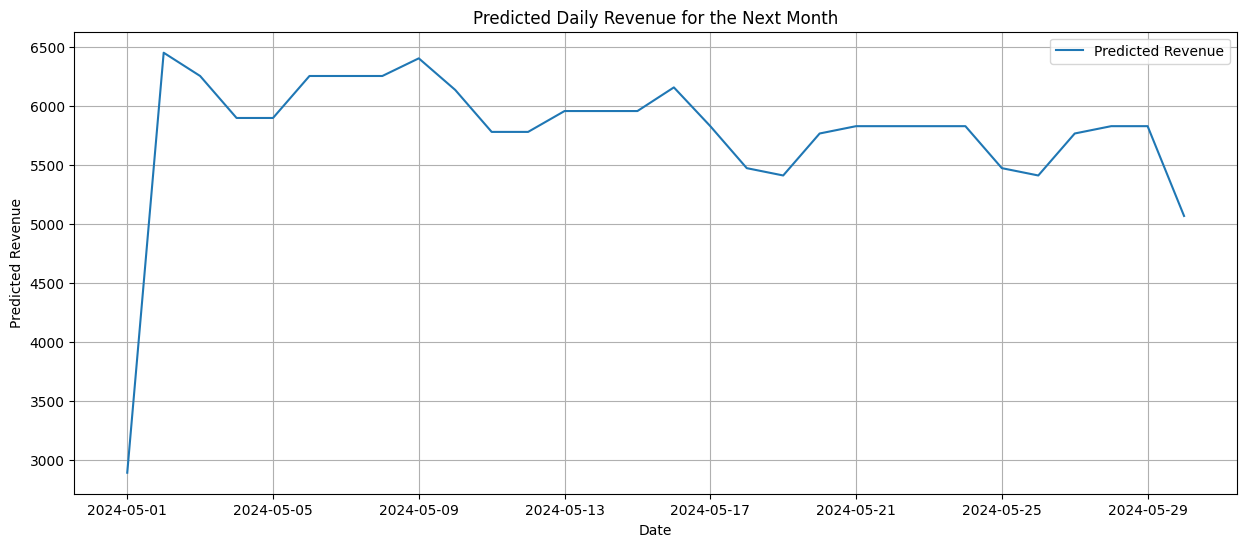


Predicted Daily Revenue for the Next Month:
2024-05-01    2894.728271
2024-05-02    6448.773438
2024-05-03    6251.883301
2024-05-04    5896.612793
2024-05-05    5896.612793
2024-05-06    6251.883301
2024-05-07    6251.883301
2024-05-08    6251.883301
2024-05-09    6401.223633
2024-05-10    6134.020020
2024-05-11    5778.749512
2024-05-12    5778.749512
2024-05-13    5955.283691
2024-05-14    5955.283691
2024-05-15    5955.283691
2024-05-16    6155.351074
2024-05-17    5827.274414
2024-05-18    5472.003906
2024-05-19    5410.019043
2024-05-20    5765.289551
2024-05-21    5827.274414
2024-05-22    5827.274414
2024-05-23    5827.274414
2024-05-24    5827.274414
2024-05-25    5472.003906
2024-05-26    5410.019043
2024-05-27    5765.289551
2024-05-28    5827.274414
2024-05-29    5827.274414
2024-05-30    5067.403320
Freq: D, Name: predicted_revenue, dtype: float32


,day_of_week,month,day,is_holiday,predicted_revenue
2024-05-01,2,5,1,0,2894.728271
2024-05-02,3,5,2,0,6448.773438
2024-05-03,4,5,3,0,6251.883301
2024-05-04,5,5,4,0,5896.612793
2024-05-05,6,5,5,0,5896.612793
2024-05-06,0,5,6,1,6251.883301
2024-05-07,1,5,7,0,6251.883301
2024-05-08,2,5,8,0,6251.883301
2024-05-09,3,5,9,0,6401.223633
2024-05-10,4,5,10,0,6134.020020


In [27]:
# Plot forecasted revenue
plt.figure(figsize=(15, 6))
plt.plot(future_df.index, future_df['predicted_revenue'], label='Predicted Revenue')
plt.title('Predicted Daily Revenue for the Next Month')
plt.xlabel('Date')
plt.ylabel('Predicted Revenue')
plt.legend()
plt.grid(True)
plt.show()

# Print forecasted values
print("\nPredicted Daily Revenue for the Next Month:")
print(future_df['predicted_revenue'])
future_df
